In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import fastcluster
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from ete3 import NCBITaxa, Tree, ProfileFace, AttrFace, TreeStyle, BarChartFace
ncbi = NCBITaxa()

# Plot the NCBI classification tree from file

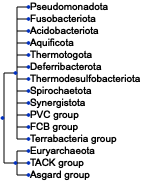

In [6]:
ProkaryoticOrders = Tree("../Data/input/ProkaryotTree.nw", format=9)# made using orthofinder, NCBI ID's are slightly different to the ones from the strains in EggNOG so that's corrected in the .nw file.

ts = TreeStyle()
ts.draw_guiding_lines = True
ts.show_leaf_name = True
ts.scale =  10
ts.show_scale = False
ProkaryoticOrders.swap_children()


ProkaryoticOrders.render("%%inline", tree_style=ts,dpi=100)

In [7]:
order = [1224,32066,57723,200783,200918,200930,200940,203691,508458,1783257,1783270,1783272,28890,1783275,1935183]

# Load the OG DataFrame

In [15]:
#Root_OG_Counts = pd.read_pickle("../Data/output/AllOFOG&eOGCounts.pkl")
Root_OG_Counts = pd.read_csv("../Data/output/AllOFOG&eOGCounts.csv", index_col = 0)
Root_OG_Counts.head()

,1000565,1000569,1000570,1000588,1001240,1001530,1001585,100226,1002339,1002340,...,UP000751408,UP000760201,UP000771954,UP000775429,UP000777023,UP000825566,UP000825906,UP000826397,UP000826686,UP000826833
COG,,,,,,,,,,,,,,,,,,,,,
28H50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28H51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28H52,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28H53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28H54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Open the list of clusters of orthologous groups of interest 

In [19]:
COGsOI = pd.read_csv("../Data/input/AllWLPGenes.csv", sep =";", comment = "#", header = 0).iloc[:,[0,1,6,7]]
COGsOI = COGsOI.loc[:,["Category","Group","GeneName","COG"]]
COGsOI

,Category,Group,GeneName,COG
0,Metabolic,MFR,fmdC,COG2218
1,Metabolic,THMPT,ftr,COG2037
2,Metabolic,THMPT,mch,COG3252
3,Metabolic,THMPT,mtd,COG1927
4,Metabolic,THMPT,mer,COG2141
5,Metabolic,THMPT,mtrH,COG1962
6,Metabolic,THF,fdhA,COG3383
7,Metabolic,THF,fhs,COG2759
8,Metabolic,THF,folD,COG0190
9,Metabolic,THF,mtdA,COG0373


In [20]:
Root_COGsOI_Counts = Root_OG_Counts.loc[COGsOI.COG]

# By Genus

In [21]:
Taxonomy = pd.DataFrame(index = Root_COGsOI_Counts.columns)
Taxonomy["Kingdom"] = "NaN"
Taxonomy["Order"] = "NaN"

for ID in Taxonomy.index:
    if ID.startswith("UP"):
        Taxonomy.Kingdom[ID] = 2157
        Taxonomy.Order[ID] = 1935183
    else: 
        Taxonomy.Kingdom[ID] = ncbi.get_lineage(ID)[2]
        Taxonomy.Order[ID] = ncbi.get_lineage(ID)[3]

#Drop Eukarya
Taxonomy = pd.DataFrame(Taxonomy[~Taxonomy.Kingdom.isin([2759])])

#Drop incertae sedis orders
Taxonomy = pd.DataFrame(Taxonomy[~Taxonomy.Order.isin([2323,49928])])
             
SpeciesCount = Taxonomy.groupby("Order").size()
SpeciesCount

/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1046724 was translated into 2739064
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1104325 was translated into 1158600
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1118055 was translated into 33037
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1121105 was translated into 1255705
  warnings.warn("taxid %s was translated into %s" %(taxi

Order
1224       1555
28890       120
29547        80
32066        30
40117         4
57723        16
68297         2
200783       16
200918       17
200930        6
200938        2
200940       78
203691       48
508458       15
1783257      52
1783270     428
1783272    2060
1783275      41
1802340       1
1930617       1
1935183      68
2138240       2
2283796       7
2498710       1
2818505      15
3018035       8
dtype: int64

# Prune tree to drop orders with fewer than 5 members

In [22]:
RootOGs = Root_COGsOI_Counts > 0
RootOGs.head()

,1000565,1000569,1000570,1000588,1001240,1001530,1001585,100226,1002339,1002340,...,UP000751408,UP000760201,UP000771954,UP000775429,UP000777023,UP000825566,UP000825906,UP000826397,UP000826686,UP000826833
COG,,,,,,,,,,,,,,,,,,,,,
COG2218,True,False,False,False,False,False,False,False,False,True,...,True,True,False,False,True,True,False,True,False,False
COG2037,True,False,False,False,False,False,False,False,False,False,...,True,True,True,False,True,True,False,True,True,False
COG3252,True,False,False,False,False,False,False,False,False,False,...,True,True,True,False,True,True,False,True,True,False
COG1927,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,True,True,False
COG2141,True,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [23]:
data = RootOGs.T.merge(Taxonomy, how = "left", left_index=True, right_index=True).drop(columns = "Kingdom")#.groupby(["Group"])

#Group by Taxonomic order
data = data.groupby(data.iloc[:,-1]).sum()

#Convert to a percentage of species for each order
data = data.divide(SpeciesCount, axis=0).loc[order]

data.head()

/var/folders/qr/vm827mh53sd6708z2k3_tnnrz3fj08/T/ipykernel_24306/3003098859.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(data.iloc[:,-1]).sum()


,COG2218,COG2037,COG3252,COG1927,COG2141,COG1962,COG3383,COG2759,COG0190,COG0373,COG0685,COG1410,COG1880,COG2069,COG1456,COG1151,COG1152,COG1614,COG0280,COG0282
Order,,,,,,,,,,,,,,,,,,,,
1224,0.180707,0.063023,0.061736,0.0,0.754984,0.000643,0.652090,0.317685,0.977492,0.639228,0.910611,0.847588,0.000643,0.0000,0.001286,0.0,0.027653,0.0000,0.906752,0.663666
32066,0.000000,0.000000,0.000000,0.0,0.233333,0.000000,0.333333,0.966667,1.000000,0.866667,0.700000,0.700000,0.000000,0.0000,0.000000,0.0,0.000000,0.0000,1.000000,1.000000
57723,0.000000,0.000000,0.000000,0.0,0.812500,0.000000,1.000000,0.250000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0625,0.062500,0.0,0.000000,0.0625,0.375000,0.937500
200783,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.687500,0.000000,1.000000,1.000000,1.000000,0.437500,0.500000,0.0000,0.000000,0.0,0.062500,0.0000,0.000000,0.062500
200918,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.117647,0.823529,0.941176,0.000000,0.0000,0.058824,0.0,0.000000,0.0000,1.000000,1.000000


plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False

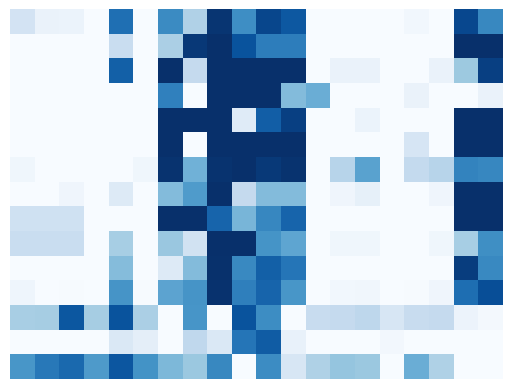

In [24]:
plt.imshow(data[COGsOI.COG], cmap='Blues', interpolation='nearest')
#plt.savefig("../Figures/SpeciesCountHeatmap.png", dpi=300)
plt.tick_params(left = False, bottom = False)
plt.axis('off')
plt.show()